# Using an auto encoder on MNIST handwritten digits.

In this tutorial, we are going to learn how to compress handwritten digit images from MNIST dataset and reconstruct them by using [autoencoder](https://en.wikipedia.org/wiki/Autoencoder)　algorithm. The autoencoder model is mainly composed of an ***encoder*** and a ***decoder***. As you can see in the following diagram(*credit to this* [blog](https://blog.keras.io/building-autoencoders-in-keras.html)) of the model architecture, ***after the original input is fed through the encoder and decoder layer, the target output is expected to be the same as the input although there could be lost information actually after reconstruction***, which is the key point of autoencoder. It's a very basic and limited data compression algorithm but still good enough for practical applications such as data denoising and dimensionality reduction for data visualization.

![model_architecture](tutorial_images/autoencoder/autoencoder_schema.jpg)

Without further ado, let's finish some imports and setups before the experiment and then delve into the code illustration.

In [28]:
import matplotlib
matplotlib.use('Agg')
#%pylab inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from bigdl.nn.criterion import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
from utils import get_mnist
from pyspark import SparkContext
from zoo.common.nncontext import *
from zoo.pipeline.api.keras.layers import *
from zoo.pipeline.api.keras.models import *
from zoo.pipeline.api.autograd import *

sc = get_nncontext()


# 1. Load MNIST dataset

Read the training data and test data from our designated dataset path by using `get_mnist` method. It also pre-processes the data by standardizing the image pixel values for better neural network performance.

Please edit the "mnist_path" accordingly. If the "mnist_path" directory does not consist of the mnist data, the `get_mnist`  method will download the dataset directly to the directory.

In [21]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "datasets/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)
train_data = train_data.map(lambda sample:
            Sample.from_ndarray(np.resize(sample.features[0].to_ndarray(), (28*28,)), np.resize(sample.features[0].to_ndarray(), (28*28,))))
test_data = test_data.map(lambda sample:
            Sample.from_ndarray(np.resize(sample.features[0].to_ndarray(), (28*28,)), np.resize(sample.features[0].to_ndarray(), (28*28,))))

print train_data.count()
print test_data.count()

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


# 2. Model setup

Specify the initial hyperparameters prior to the training.

In [22]:
# Parameters
training_epochs = 10
batch_size = 128
display_step = 1

# Network Parameters
n_hidden = 32
n_input = 784 # MNIST data input (img shape: 28*28)

# 3. Model creation

By introducing non-lineararity into our autoencoder model, the activation layer ***ReLU*** and ***Sigmoid*** are added into encoder and decoder respectively.

In [23]:
# Create Model

def build_autoencoder(n_input, n_hidden):
    # Initialize a sequential container
    model = Sequential()

    # encoder
    model.add(Dense(n_hidden, input_shape=[n_input]))
    model.add(Activation("relu"))
    # decoder
    model.add(Dense(n_input))
    model.add(Activation("sigmoid"))
    
    return model
model = build_autoencoder(n_input, n_hidden)

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasActivation
creating: createZooKerasDense
creating: createZooKerasActivation


# 4. Optimizer setup

In [24]:
# compile the model

def mean_square_error(y_true, y_pred):
    result = mean(square(y_true - y_pred), axis=1)
    return result

model.compile(optimizer=Adam(),
                  loss=mean_square_error, #MSECriterion(),
                  metrics=None)
app_name='autoencoder-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")

model.set_tensorboard(log_dir='/tmp/zoo_summaries',
                                     app_name=app_name)
print "saving logs to ",app_name

creating: createAdam
creating: createZooKerasVariable
creating: createZooKerasVariable
creating: createZooKerasCustomLoss
saving logs to  autoencoder-20180509-163310


In [25]:
%%time
# Boot training process
model.fit(x=train_data,
              batch_size=batch_size,
              nb_epoch=2,
              validation_data=None)
trained_model = model

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 19.9 s


# 5. Loss visualization

* During the training, you can run tensorboard command showed below to visualize the training metrics, like LearningRate curve, Loss curve, and Paramters's histogram.
Run tensorboard command(tensorboard --logdir=/tmp/tmpvE6hzB, notice logdir will change in each run) to start tensorboard: 

![scalars](pictures/tb-start.png)

You can add command flag `--port` to use another port, if the defaut 6006 is unavailable.

Then, open your browser and type in TensorBoard's http address. From tensorboard's scalar tab, you can see the LearningRate curve and Loss curve like this:
![scalars](pictures/tb-scalars.png)

In [26]:
#tensorboard --logdir=/tmp/zoo_summaries

# 6. Prediction on test dataset

Then we test our autoencoder from the previous loaded dataset, compress and reconstruct the digit images then compare the results with the original inputs, which are also our target outputs. We are going to use only 10 examples to demonstrate our created and trained autoencoder is working.

('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')


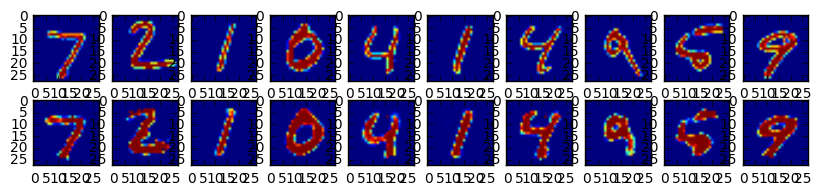

In [27]:
(images, labels) = mnist.read_data_sets(mnist_path, "test")
examples_to_show = 10
examples = trained_model.predict(test_data).take(examples_to_show)
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(images[i], (28, 28)))
    a[1][i].imshow(np.reshape(examples[i], (28, 28)))